In [1]:
import onnxruntime
print("onnxruntime version: ", onnxruntime.__version__)

onnxruntime version:  1.17.1


In [2]:
from cupyx import scipy


In [44]:
import ffmpegcv
import cupy as cp
import time

import ffmpegcv
import cupy as cp
import time

class Camera:
    def __init__(
        self, source, display_fps=False, save_video=False, output_file="output.mp4"
    ):
        self.display_fps = display_fps
        self.frame_count = 0
        self.start_time = time.time()

        self.save_video = save_video
        if self.save_video:
            # Define the codec and create a VideoWriter object
            width = 640
            height = 480
            fps = 30

            # Initialize ffmpegcv for video writing
            self.out = ffmpegcv.VideoWriter(output_file, width, height, fps)

        # Initialize ffmpegcv for video capture
        self.cap = ffmpegcv.VideoCapture(source, codec='h264_cuvid', pix_fmt='rgb24')

    def get_frame(self, process_frame=None):
        ret, frame = self.cap.read()
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            return None
        if process_frame:
            frame = process_frame(frame)
        self.frame_count += 1
        return frame

    def display_frame(self, frame, info=None):
        # Note: Displaying frames directly with CuPy or ffmpegcv is not straightforward
        # You might need to convert the frame to a format that can be displayed
        # For example, converting to a NumPy array and using OpenCV for display
        if self.display_fps:
            fps = self.get_fps()
            # Display FPS and info using OpenCV or another library
            pass
        if self.save_video:
            # Write the frame to the output file
            # Note: You might need to convert the frame to a format compatible with ffmpegcv
            self.out.write(frame)

    def release(self):
        self.cap.release()
        if self.save_video:
            self.out.release()

    def wait_key(self, key_to_quit="q"):
        # Note: ffmpegcv does not support waitKey
        # You might need to implement a different mechanism for key press detection
        pass

    def get_fps(self):
        elapsed_time = time.time() - self.start_time
        return self.frame_count / elapsed_time

    def set_fps(self, fps):
        # Note: Setting FPS might not be directly supported by ffmpegcv
        pass

    def resize_frame(self, frame, width, height):
        # Convert frame to CuPy array if not already
        frame_cp = cp.asarray(frame)
        # Resize the frame using CuPy
        resized_frame = cp.resize(frame_cp, (height, width))
        # Convert back to a format compatible with ffmpegcv or display
        return cp.asnumpy(resized_frame)


In [37]:
import cupy as cp
from typing import Tuple
import cupyx
from cucim.skimage import transform



def resize_and_pad(original_img: cp.ndarray
) -> Tuple[cp.ndarray, float, Tuple[int, int]]:
    """
    Resize and pad the input image to the desired model input size
    """
    original_shape = original_img.shape[:2]
    
    target_size = (640, 640)

    resize_ratio = cp.minimum( target_size[0] / original_shape[0], target_size[1] / original_shape[1]
    )
    print(f"Resize ratio: {resize_ratio}")

    resized_dimensions = int(cp.round(original_shape[1] * resize_ratio)), int(
        cp.round(original_shape[0] * resize_ratio)
    )

    print(f"Resized dimensions: {resized_dimensions}")

    # Calculate the necessary padding for the resized image to fit the desired size
    padding_width, padding_height = (target_size[1] - resized_dimensions[0]) / 2, (
        target_size[0] - resized_dimensions[1]
    ) / 2

    print(f"Padding width: {padding_width}, padding height: {padding_height}")

    # Resize the image while maintaining aspect ratio
    resized_image = transform.resize(
        original_img, (resized_dimensions[1], resized_dimensions[0]), anti_aliasing=True
    )

    # Add padding to the resized image
    padding_top, padding_bottom = int(cp.round(padding_height - 0.1)), int(
        cp.round(padding_height + 0.1)
    )
    padding_left, padding_right = int(cp.round(padding_width - 0.1)), int(
        cp.round(padding_width + 0.1)
    )
    padded_image = cp.pad(
        resized_image,
        ((padding_top, padding_bottom), (padding_left, padding_right), (0, 0)),
        mode="constant",
        constant_values=114,
    )

    return padded_image, resize_ratio, (padding_width, padding_height)

/tmp/ipykernel_52453/513573742.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = iio.imread("test_samples/images/cars.jpg")


Resize ratio: 0.5333333333333333
Resized dimensions: (640, 360)
Padding width: 0.0, padding height: 140.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img_padded shape: (640, 640, 3)


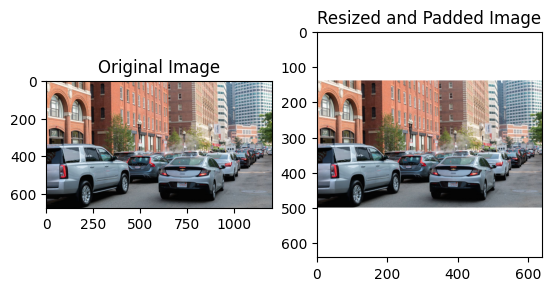

In [38]:
import cupy as cp
from cupyx.scipy.ndimage import zoom
import matplotlib.pyplot as plt
import imageio as iio
from cucim.skimage import transform


# read the image
img = iio.imread("test_samples/images/cars.jpg")
img = cp.asarray(img)

plt.subplot(1, 2, 1)
plt.imshow(cp.asnumpy(img))
plt.title("Original Image");

img_padded =resize_and_pad(img)
print(f"img_padded shape: {img_padded[0].shape}")

plt.subplot(1, 2, 2)
plt.imshow(cp.asnumpy(img_padded[0]))
plt.title("Resized and Padded Image");


max and min pixelated_image: 255, 0
max and min image_cp: 255, 0


(-0.5, 1199.5, 674.5, -0.5)

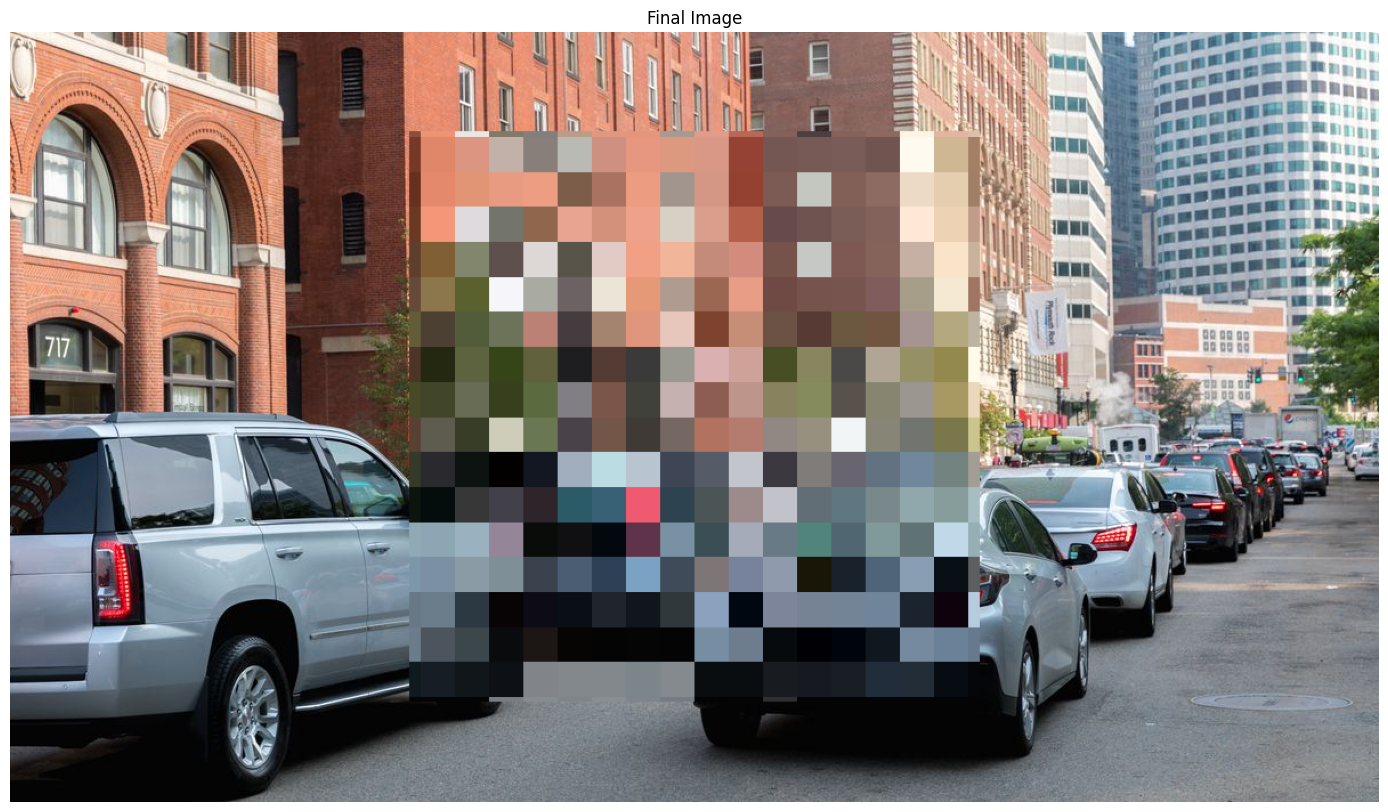

In [91]:
import matplotlib.pyplot as plt
import imageio.v2 as iio
import cupy as cp
from cucim.skimage import transform

#test_samples/images/cars.jpg
rescale = 30
image_np= iio.imread("test_samples/images/cars.jpg")
image_cp = cp.asarray(image_np, dtype=cp.uint8)
# mask
mask = cp.ones((675 ,1200), dtype=cp.uint8) * 255
square_size = 500 # Example size, adjust as needed
start_x = (mask.shape[0] - square_size) // 2
start_y = (mask.shape[1] - square_size) // 2
mask[start_x:start_x + square_size, start_y:start_y + square_size] = 0

# where is 0 turn to 255 and where is 255 turn to 0
mask_inv = cp.where(mask == 0, 255, 0)
mask = cp.repeat(mask[..., None], 3, axis=-1)

pixelated_image = transform.resize(image=image_cp, order=0, output_shape=(image_cp.shape[0] // rescale, image_cp.shape[1] // rescale), preserve_range=True, anti_aliasing=False)
pixelated_image = transform.resize(image= pixelated_image, order=0,output_shape=(image_cp.shape[0], image_cp.shape[1]), preserve_range=True, anti_aliasing=False)

# where mask is 0, keep pixelated image, otherwise keep original image
final_image = cp.where(mask == 0, pixelated_image, image_cp)

# Convert the pixelated image to integers
pixelated_image = cp.rint(pixelated_image).astype(cp.uint8)

# Convert the final image to integers
final_image = cp.rint(final_image).astype(cp.uint8)

# Now you can print the max and min values of the images
print(f"max and min pixelated_image: {cp.max(pixelated_image)}, {cp.min(pixelated_image)}")
print(f"max and min image_cp: {cp.max(image_cp)}, {cp.min(image_cp)}")


# image plot size
plt.figure(figsize=(22, 10))


plt.imshow(final_image.get())
plt.title("Final Image")
plt.axis("off")


In [ ]:
def apply_pixelate(self, image: cp.ndarray, mask: cp.ndarray, rescale: int = 30) -> cp.ndarray:
    
    image_cp = cp.asarray(image, dtype=cp.uint8)
    
    
    pixelated_img_small = transform.resize(image=image_cp, 
                                           order=0, 
                                           output_shape=(image_cp.shape[0] // rescale, image_cp.shape[1] // rescale), 
                                           preserve_range=True, 
                                           anti_aliasing=False)
    pixelated_image = transform.resize(image= pixelated_img_small, 
                                       order=0,
                                       output_shape=(image_cp.shape[0], image_cp.shape[1]), 
                                       preserve_range=True, 
                                       anti_aliasing=False)

    mask = mask.astype(cp.uint8) * 255
    mask = cp.repeat(mask[..., None], 3, axis=-1)
    final_image = cp.where(mask == 0, pixelated_image, image_cp)

    return final_image
    
    
    
    mask = mask.astype(cp.uint8) * 255
    pixelated_image = cv2.resize(
        image, (0, 0), fx=0.03, fy=0.03, interpolation=cv2.INTER_NEAREST
    )
    zoom(image, (scale_factor, scale_factor, 1), order=0, prefilter=False)
    pixelated_image = cv2.resize(
        pixelated_image,
        (image.shape[1], image.shape[0]),
        interpolation=cv2.INTER_NEAREST,
    )
    mask_inv = cv2.bitwise_not(mask)
    final_image = cv2.bitwise_and(image, image, mask=mask_inv) + cv2.bitwise_and(
        pixelated_image, pixelated_image, mask=mask
    )
    return final_image

In [84]:
import matplotlib.pyplot as plt
import imageio.v2 as iio
import cupy as cp

# Read the input image
image_path = "test_samples/images/cars.jpg"
image_np = iio.imread(image_path)
image_cp = cp.asarray(image_np, dtype=cp.uint8)

# Create the mask
mask_size = (image_cp.shape[0], image_cp.shape[1])
mask = cp.ones(mask_size, dtype=cp.uint8) * 255
square_size = 500
start_x = (mask.shape[0] - square_size) // 2
start_y = (mask.shape[1] - square_size) // 2
mask[start_x : start_x + square_size, start_y : start_y + square_size] = 0
mask = mask[..., None]
mask = cp.repeat(mask, 3, axis=-1)

# Perform pixelation
rescale = 30
small_shape = (image_cp.shape[0] // rescale, image_cp.shape[1] // rescale, image_cp.shape[2])
pixelated_image = image_cp.reshape((-1, rescale, image_cp.shape[1], image_cp.shape[2])).mean(axis=(1, 2))
pixelated_image = cp.repeat(pixelated_image, rescale, axis=0).repeat(rescale, axis=1)


# Adjust the mask to match the pixelated_image shape
mask_resized = cp.repeat(mask, rescale, axis=0).repeat(rescale, axis=1)
mask_resized = cp.where(mask_resized == 0, 1, 0).astype(cp.bool_)

# Apply the mask to the original image
final_image = cp.where(mask_resized, pixelated_image, image_cp)

# Convert the final image to integers
final_image = cp.rint(final_image).astype(cp.uint8)

# Print the max and min values of the images
print(f"max and min pixelated_image: {cp.max(pixelated_image)}, {cp.min(pixelated_image)}")
print(f"max and min image_cp: {cp.max(image_cp)}, {cp.min(image_cp)}")

# Plot the final image
plt.figure(figsize=(22, 10))
plt.imshow(final_image.get())
plt.title("Final Image")
plt.axis("off")
plt.show()


ValueError: cannot reshape array of size 2430000 into shape (-1, 30, 1200, 3)

In [85]:
import cupy as cp

# Get cuDNN version
if cp.cuda.runtime.has_cudnn:
    print("cuDNN is available")
else:
    print("cuDNN is not available")


AttributeError: module 'cupy_backends.cuda.api.runtime' has no attribute 'has_cudnn'

In [8]:
import cupy as cp

# Check if GPU is available
if cp.cuda.runtime.getDeviceCount() > 0:
    print("GPU is available")
    # Create a CuPy array and perform a calculation to test the GPU
    x = cp.array([1, 2, 3, 4, 5])
    y = cp.sum(x)
    print(f"Sum: {y}")
else:
    print("GPU is not available")
    

GPU is available
Sum: 15


In [1]:
import cupy as cp

try:
    # Get cuDNN version
    cudnn_version = cp.cuda.cudnn.getVersion()
    print(f"cuDNN is available, version: {cudnn_version}")
except Exception as e:
    print("cuDNN is not available")

cuDNN is not available


In [1]:
import cupy as cp

# Get cuDNN version
cudnn_version = cp.cuda.cudnn.getVersion()
print(f"cuDNN is available, version: {cudnn_version}")


AttributeError: module 'cupy.cuda' has no attribute 'cudnn'